In [1]:
import proplot
import torch
import numpy as np
import matplotlib.pylab as pl
import sklearn
from sklearn import datasets
import ot
import proplot as plot

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
torch.CUDA_LAUNCH_BLOCKING=1

print('Used device: '+device)

Used device: cpu


In [3]:
get_rot= lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
def make_blobs_reg(n_samples, n_blobs, scale=.5):
    per_blob=int(n_samples/n_blobs)
    result = np.random.randn(per_blob,2) * scale + 5
    theta=(2*np.pi)/(n_blobs)
    for r in range(1,n_blobs):
        new_blob=(np.random.randn(per_blob,2) * scale + 5).dot(get_rot(theta*r))
        result = np.vstack((result,new_blob))
    return result

# random MoG
def make_blobs_random(n_samples, n_blobs, scale=.5, offset=3):
    per_blob=int(n_samples/n_blobs)
    result = np.random.randn(per_blob,2) * scale + np.random.randn(1,2)*offset
    for r in range(1,n_blobs):
        new_blob=np.random.randn(per_blob,2) * scale + np.random.randn(1,2)*offset
        result = np.vstack((result,new_blob))
    return result

#%%
def make_spiral(n_samples, noise=.5):
    n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
    return np.array(np.hstack((d1x,d1y)))

In [4]:
def sort_to_plan(u):
    n=u.shape[0]
    temp=torch.arange(n)
    P=torch.zeros((n,n))
    P[u,temp]=1#/n
    return P

In [6]:
def upperW2_blur(X,Y,theta,s=1,std=0):
    n=X.shape[0]
    
    X_line=torch.matmul(X,theta)
    Y_line=torch.matmul(Y,theta)
    
    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
    
    X_sort=X[u]
    Y_sort=Y[v]
    
    Z_line=(X_line_sort+Y_line_sort)/2
    Z=Z_line[:,None]*theta[None,:]
    
    W_XZ=torch.sum((X_sort-Z)**2)/n
    W_YZ=torch.sum((Y_sort-Z)**2)/n
    
    X_line_extend=X_line.repeat_interleave(s,dim=0)
    X_line_extend_blur=torch.normal(X_line_extend,std)
    
    Y_line_extend=Y_line.repeat_interleave(s,dim=0)

    X_line_extend_blur_sort,u=torch.sort(X_line_extend_blur,axis=0)
    Y_line_extend_sort,v=torch.sort(Y_line_extend,axis=0)
    
    X_extend=X.repeat_interleave(s,dim=0)
    Y_extend=Y.repeat_interleave(s,dim=0)
    X_sort_extend=X_extend[u]
    Y_sort_extend=Y_extend[v]

    Z_line_extend=Z_line.repeat_interleave(s,dim=0)
    Z_extend=Z_line_extend[:,None]*theta[None,:]
    
    bary_extend=(X_sort_extend+Y_sort_extend)/2
    W_baryZ=torch.sum((bary_extend-Z_extend)**2)/(s*n)
        
    return -4*W_baryZ+2*W_XZ+2*W_YZ

In [7]:
def maxSW2(xs,xt,proj): #add a seed?
    
    xs_line=torch.matmul(xs.float(),proj[:,None].float())
    xt_line=torch.matmul(xt.float(),proj[:,None].float())
    
    xs_line_sorted,_=torch.sort(xs_line,axis=0)
    xt_line_sorted,_=torch.sort(xt_line,axis=0)
    W_1d = torch.sum((xs_line_sorted-xt_line_sorted)**2)
    
    return W_1d

In [8]:
def get_minSW(Xa,Xb,lr=1e-2,num_iter=100,s=1,std=0):
    theta=torch.randint(1,2, (Xa.shape[1],),requires_grad=True, device=Xa.device, dtype=Xa.dtype)
    optimizer = torch.optim.Adam([theta], lr=lr)
    loss_l=[]
    for i in range(num_iter):
        # build projector
        proj = theta/torch.norm(theta)
        loss = upperW2_blur(Xa.float(),Xb.float(),proj.float().T,s=s,std=std)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_l.append(loss.data)
    return theta, loss_l

In [9]:
def get_maxSW(Xa,Xb,lr=1e-2,num_iter=100):
    theta=torch.randint(1, 2, (Xa.shape[1],),requires_grad=True, device=Xa.device, dtype=Xa.dtype)
    optimizer = torch.optim.Adam([theta], lr=lr)
    loss_l=[]
    proj = theta/torch.norm(theta)
    for i in range(num_iter):
        # build projector
        loss = -maxSW2(Xa.float(),Xb.float(),proj.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_l.append(-loss.data)
        proj = theta/torch.norm(theta)
    return theta, loss_l

In [10]:
def make_data(expe,n_samples,dim=2):
    if expe=='spirals':
        r=2.5
        xs = make_spiral(n_samples=n_samples, noise=1)
        xt = make_spiral(n_samples=n_samples, noise=1).dot(get_rot(r))
    elif expe=='mog_reg':
        r=.5
        xs = make_blobs_reg(n_samples=n_samples, n_blobs=3)
        xt = make_blobs_reg(n_samples=n_samples, n_blobs=3).dot(get_rot(r))
    elif expe=='mog_random':
        xs = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=10)
        xt = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=10)
    elif expe=='custom':
        xs = make_blobs_random(n_samples=n_samples, scale=.3,n_blobs=1,offset=0)-6
        xt = make_spiral(n_samples=n_samples, noise=1)
    elif expe=='two_moons':
        X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.05)
        xs = X[y==0,:]
        xt = X[y==1,:]
    elif expe=='gaussians' :
        mu_s = np.random.randint(-10,10,dim)
        #mu_s = np.random.randint(-1,1,dim)
        #mu_s=np.array([-50,-50])
        cov_s = np.diag(np.random.randint(1,5,dim))
        cov_s = cov_s * np.eye(dim)
        #cov_s=np.array([[1,0],[0,10]])
        mu_t = np.random.randint(-10,10,dim)
        #mu_t = np.random.randint(-1,1,dim)
        #mu_t=np.array([50,50])
        cov_t = np.diag(np.random.randint(1,5,dim))
        cov_t = cov_t * np.eye(dim)
        #cov_t=np.array([[1,0],[0,10]])
        xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
        xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
    return xs,xt



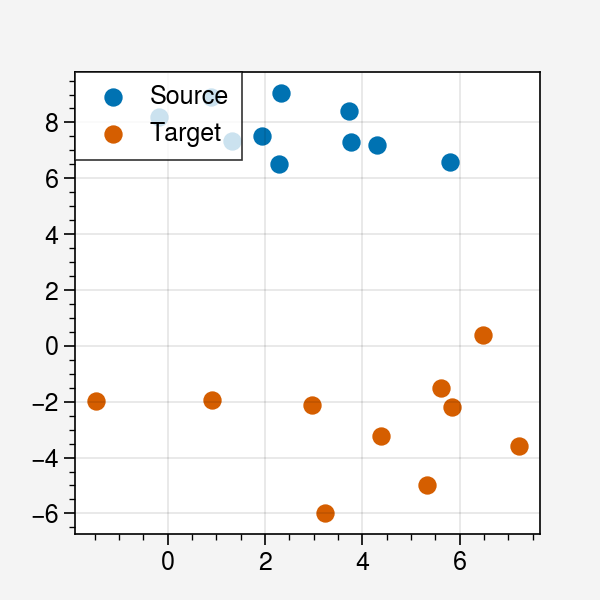

In [122]:
n=10
xs,xt=make_data('gaussians',n,dim=2)

dim=xs.shape[1]
ns=np.shape(xs)[0]
nt=np.shape(xt)[0]
a, b = np.ones((ns,)), np.ones((nt,))
pl.figure(figsize=(3,3))
pl.scatter(xs[:, 0], xs[:, 1], c='C0', label='Source')
pl.scatter(xt[:, 0], xt[:, 1], c='C1', label='Target')
pl.legend(loc=2)

X = torch.from_numpy(xs).to(device).float()
Y = torch.from_numpy(xt).to(device).float()

In [123]:
p=1
num_proj=256
thetas = np.linspace(0, 2*np.pi, num_proj)
dire = np.array([(np.cos(theta),np.sin(theta)) for theta in thetas])
dir_torch=torch.from_numpy(dire).to(device)

msw_theta = [upperW2_blur(X,Y,p.float(),s=1,std=0) for p in dir_torch]
msw_theta_blur1= [upperW2_blur(X,Y,p.float(),s=10,std=10) for p in dir_torch]
msw_theta_blur2= [upperW2_blur(X,Y,p.float(),s=20,std=10) for p in dir_torch]
msw_theta_blur3= [upperW2_blur(X,Y,p.float(),s=50,std=10) for p in dir_torch]

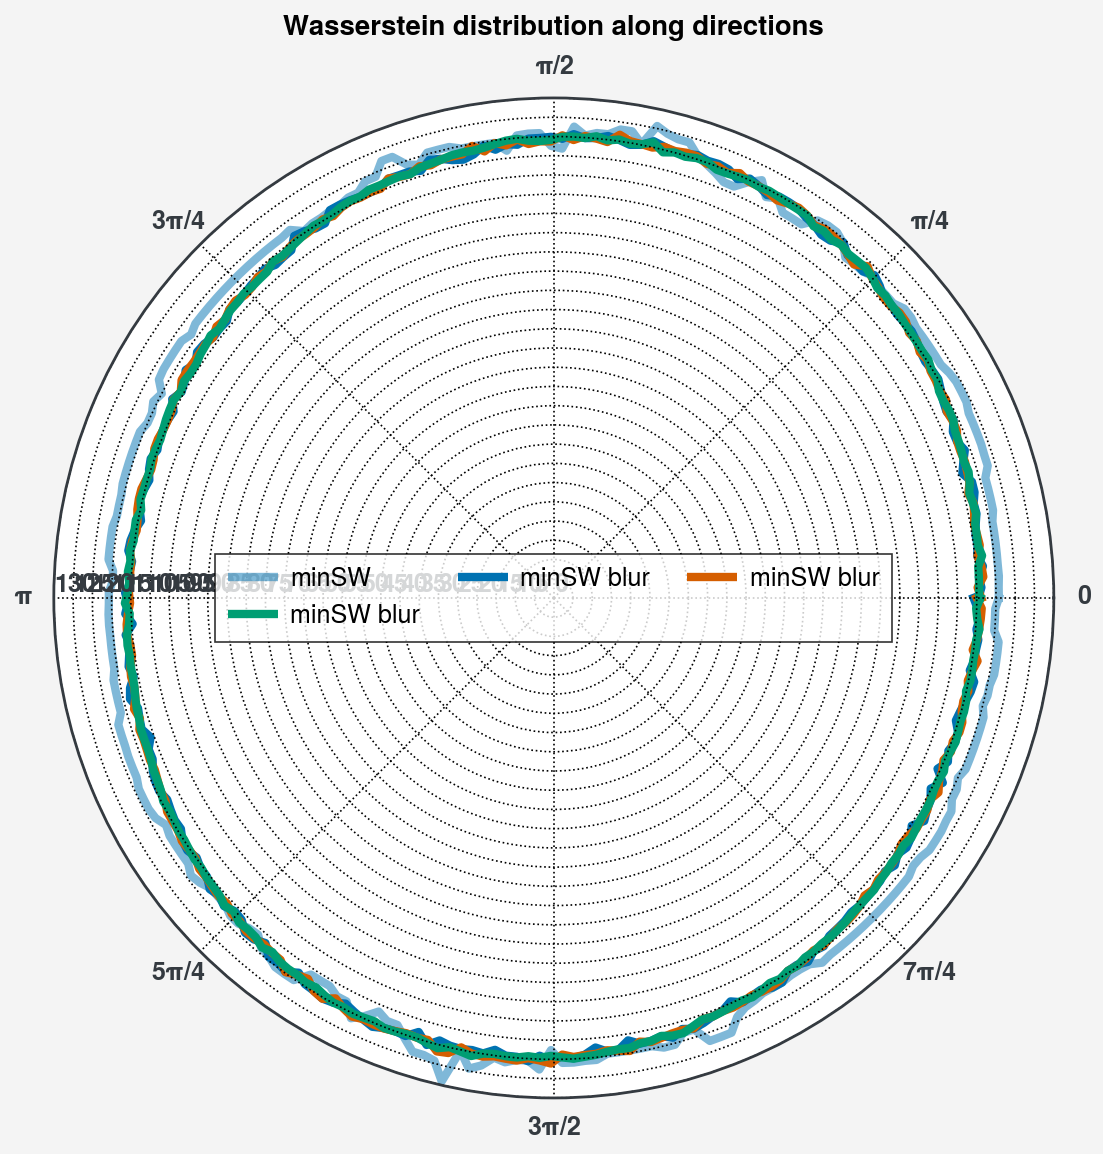

In [124]:
f, axs = plot.subplots(ncols=1, nrows=1, share=0, tight=True, axwidth=5,proj='polar')
axs.plot(thetas, msw_theta, c='C0', zorder=0, lw=3,label='minSW',alpha=.5)
axs.plot(thetas, msw_theta_blur1, zorder=0, lw=3,label='minSW blur')
axs.plot(thetas, msw_theta_blur2, zorder=0, lw=3,label='minSW blur')
axs.plot(thetas, msw_theta_blur3, zorder=0, lw=3,label='minSW blur')
axs.format(suptitle='Wasserstein distribution along directions', linewidth=1,
           ticklabelsize=9, rlines=0.5)#, r0 = np.min(msw_theta_b)-5)
axs[0].format(thetaformatter='pi', rlines=5, gridalpha=1, gridlinestyle=':',rlabelpos=180, color='gray8', ticklabelweight='bold')
axs[0].legend(loc='best')

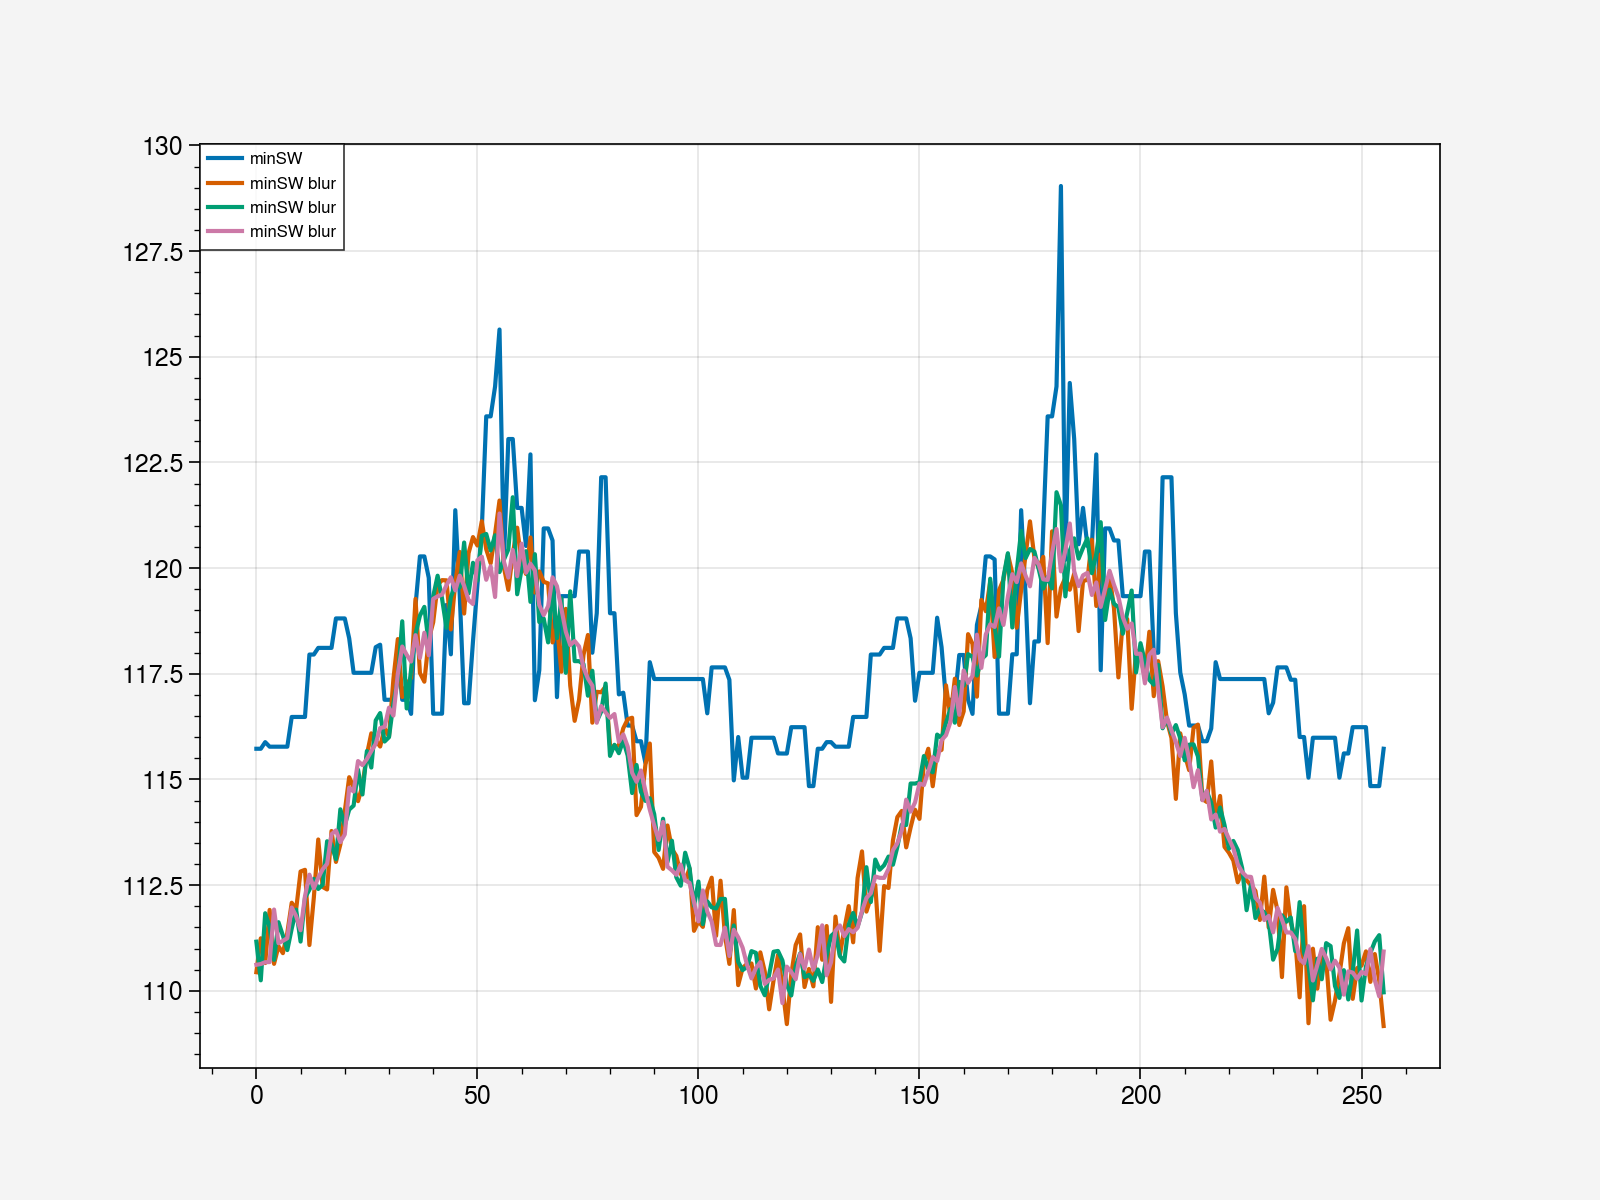

In [125]:
pl.figure(figsize=(8,6))
pl.plot(msw_theta, label="minSW")
pl.plot(msw_theta_blur1, label="minSW blur")
pl.plot(msw_theta_blur2, label="minSW blur")
pl.plot(msw_theta_blur3, label="minSW blur")
pl.legend(loc=2, prop={'size': 6})

In [126]:
lr=5e-2
num_iter=500

#Xs_torch=Xs_torch-torch.mean(Xs_torch,axis=0)
#Xt_torch=Xt_torch-torch.mean(Xt_torch,axis=0)

### minSW ###
t,loss_min_l = get_minSW(X,Y,lr=lr,num_iter=num_iter,s=1,std=0)
t.requires_grad=False
t_min=t/torch.norm(t)


### minSW blur ###
t,loss_minp_l = get_minSW(X,Y,lr=lr,num_iter=num_iter,s=100,std=1)
t.requires_grad=False
t_minp=t/torch.norm(t)

### maxSW ###
t,loss_max_l = get_maxSW(X,Y,lr=lr,num_iter=num_iter)
t.requires_grad=False
t_max=t/torch.norm(t)

Text(0.5, 1.0, 'maxSW')

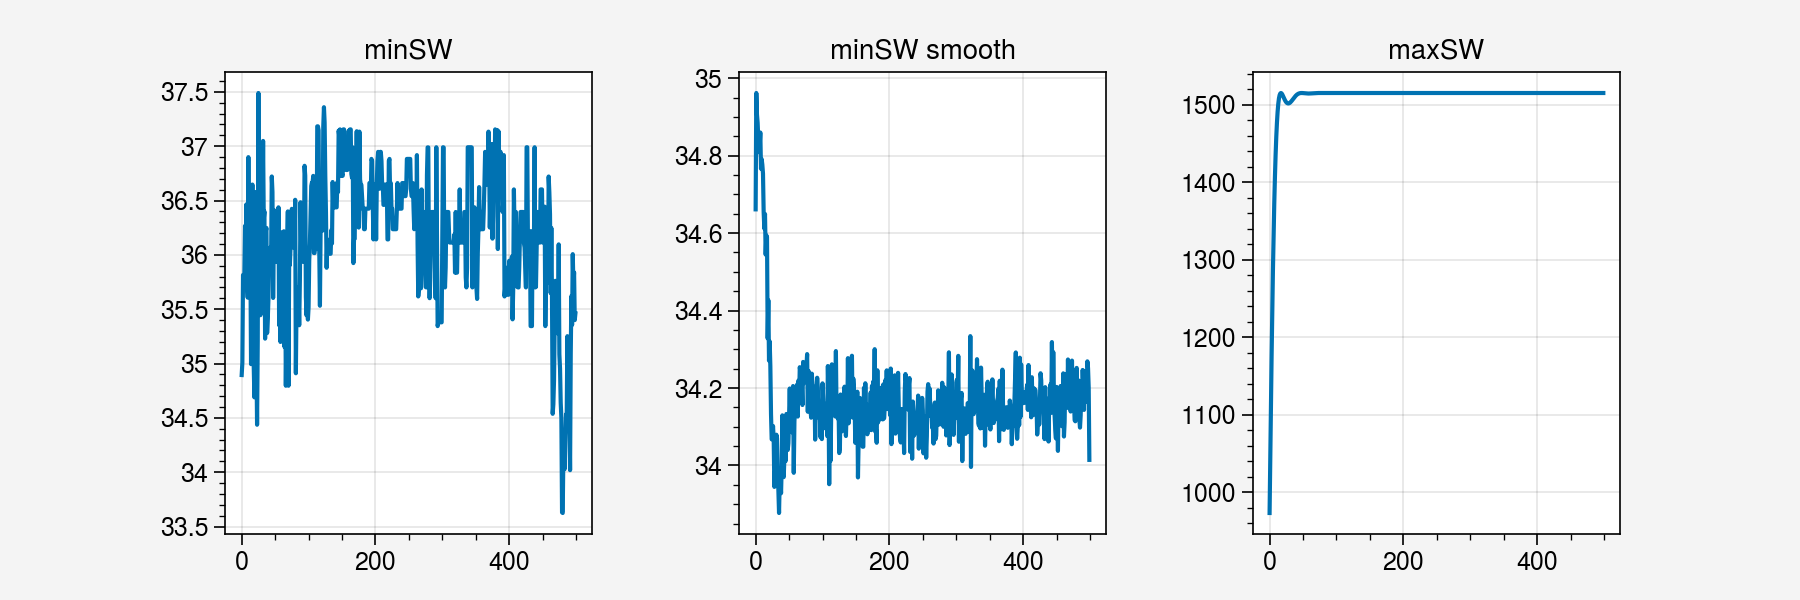

In [118]:
#print(t_min)
pl.figure(figsize=(9,3))
grid = pl.GridSpec(1, 3, wspace=0.4, hspace=0.3)

pl.subplot(grid[0, 0])
pl.plot(loss_min_l)
pl.title('minSW')

pl.subplot(grid[0, 1])
pl.plot(loss_minp_l)
pl.title('minSW smooth')

pl.subplot(grid[0, 2])
pl.plot(loss_max_l)
pl.title('maxSW')

In [98]:
print('min',min(loss_min_l))
print('minp',loss_minp_l[-1])
#print('max',loss_max_l[-1])
print(upperW2_blur(X.float(),Y.float(),t_minp.float()))

min tensor(32.2265)
minp tensor(31.6563)
tensor(32.3676)
